In [28]:
import pandas as pd

config = {'start_date' : '01/01/2025',
          'end_date' : '01/01/2025',
          'repd_name' : 'doronell',
          'elexon_id' : ['T_DOREW-1','T_DOREW-2']}

start_date = config['start_date']
end_date = config['end_date']
repd_name = config['repd_name']
elexon_id = config['elexon_id']

met_ss_api = 'eyJ4NXQjUzI1NiI6Ik5XVTVZakUxTkRjeVl6a3hZbUl4TkdSaFpqSmpOV1l6T1dGaE9XWXpNMk0yTWpRek5USm1OVEE0TXpOaU9EaG1NVFJqWVdNellXUm1ZalUyTTJJeVpBPT0iLCJraWQiOiJnYXRld2F5X2NlcnRpZmljYXRlX2FsaWFzIiwidHlwIjoiSldUIiwiYWxnIjoiUlMyNTYifQ==.eyJzdWIiOiJGYXJxdWhhcnNvbmFyQGdtYWlsLmNvbUBjYXJib24uc3VwZXIiLCJhcHBsaWNhdGlvbiI6eyJvd25lciI6IkZhcnF1aGFyc29uYXJAZ21haWwuY29tIiwidGllclF1b3RhVHlwZSI6bnVsbCwidGllciI6IlVubGltaXRlZCIsIm5hbWUiOiJzaXRlX3NwZWNpZmljLTkwMDEzZmUxLWQ1YmUtNDFjOC04YWJiLTQ1Zjc2ZjI1MTdkZCIsImlkIjoyNTQ2MywidXVpZCI6ImRhMjBhMWNiLWVhOTItNDEzNS1hOGI0LTJkMDYxNDNjYzQwYSJ9LCJpc3MiOiJodHRwczpcL1wvYXBpLW1hbmFnZXIuYXBpLW1hbmFnZW1lbnQubWV0b2ZmaWNlLmNsb3VkOjQ0M1wvb2F1dGgyXC90b2tlbiIsInRpZXJJbmZvIjp7IndkaF9zaXRlX3NwZWNpZmljX2ZyZWUiOnsidGllclF1b3RhVHlwZSI6InJlcXVlc3RDb3VudCIsImdyYXBoUUxNYXhDb21wbGV4aXR5IjowLCJncmFwaFFMTWF4RGVwdGgiOjAsInN0b3BPblF1b3RhUmVhY2giOnRydWUsInNwaWtlQXJyZXN0TGltaXQiOjAsInNwaWtlQXJyZXN0VW5pdCI6InNlYyJ9fSwia2V5dHlwZSI6IlBST0RVQ1RJT04iLCJzdWJzY3JpYmVkQVBJcyI6W3sic3Vic2NyaWJlclRlbmFudERvbWFpbiI6ImNhcmJvbi5zdXBlciIsIm5hbWUiOiJTaXRlU3BlY2lmaWNGb3JlY2FzdCIsImNvbnRleHQiOiJcL3NpdGVzcGVjaWZpY1wvdjAiLCJwdWJsaXNoZXIiOiJKYWd1YXJfQ0kiLCJ2ZXJzaW9uIjoidjAiLCJzdWJzY3JpcHRpb25UaWVyIjoid2RoX3NpdGVfc3BlY2lmaWNfZnJlZSJ9XSwidG9rZW5fdHlwZSI6ImFwaUtleSIsImlhdCI6MTc1ODEyMDY3MywianRpIjoiNDIzMWE4N2QtNDhhNC00ZDAxLTg3YjctMmY5MWYwOTkwNTBiIn0=.PuBtkHdKKohOO9P2NuiS0r9KMAfnosx1w8kY1SvPZnS0-t_iA290CwlBOvI1L8dwl51jftt2k8pF6lqDQveFl4yQ2b_SZ9zjBy1nshSppnHO1HBZSgFgneat03-ueOettyZc5VQB425Zj0zqi7e01VAFaGMu8pmVYAJDKNFipg-lrgmXumgyOe1OtrLjc6JzPfNKk0hjDB4WUy_ds1XJ79YeucrQuyR507fTc8HF5wxMe5do7na26fboic3E5XdePNDPj_-i1vle-7nqCXwEn58OE75b2EwPDAtAhw5ntdxuzexXVeATOgjhpbCbsp3kDXWIWdLoUXidwiAxy7LW6g=='

In [15]:

# wind farm of choice given that there are two but they are in the same location
# Dorenell Wind Farm
# 1. get locational data for Dorenell Wind Farm
df_loc = pd.read_csv(f'{repd_name}_repd.csv')
df_loc[['Site Name', 'Address', 'Country', 'Post Code',	'X-coordinate',	'Y-coordinate']]

,Site Name,Address,Country,Post Code,X-coordinate,Y-coordinate
0,Dorenell Wind Farm (Previously Site A and B Sc...,"Glenlivet Estate, Dufftown, Speyside, Moray",Scotland,NaN,332000,829500


In [16]:
# 2. get PN data of doronell

import concurrent.futures
import logging
import os
import sqlite3
import requests
import time
from pathlib import Path

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.exc import OperationalError, IntegrityError
from sp2ts import dt2sp

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



def add_utc_timezone(datetime):
    """ Add utc timezone to datetime. """
    if datetime.tzinfo is None:
        datetime = datetime.tz_localize('UTC')
    else:
        datetime = datetime.tz_convert('UTC')
    return datetime


def call_physbm_api(start_date, end_date, unit=None):
    """Thin wrapper to allow kwarg passing with starmap"""
    logger.info(f"Calling BOAS API for {unit}")

    # Nedd to call PNs and BOALs separately in new API

    # "https://data.elexon.co.uk/bmrs/api/v1/balancing/physical/all?dataset={dataset}&settlementDate={settlementDate}&settlementPeriod={settlementPeriod}&format=json"
    datetimes = pd.date_range(start_date, end_date, freq="30min")
    data_df = []
    for datetime in datetimes:
        logger.info(f"Getting PN from {datetime}")

        datetime = add_utc_timezone(datetime)

        date, sp = dt2sp(datetime)
        url = f"https://data.elexon.co.uk/bmrs/api/v1/balancing/physical/all?dataset=PN&settlementDate={date}&settlementPeriod={sp}"
        if unit is not None:
            url = url + f"&bmUnit={unit}"
        url = url + "&format=json"

        r = requests.get(url)

        data_one_settlement_period_df = pd.DataFrame(r.json()["data"])
        data_df.append(data_one_settlement_period_df)

    data_pn_df = pd.concat(data_df)

    datetimes = pd.date_range(start_date, end_date, freq="30min")
    data_df = []
    for datetime in datetimes:
        logger.info(f"Getting BOALF from {datetime}")
        boalf_end_datetime = (datetime + pd.Timedelta(minutes=30)).tz_localize(None)
        boalf_start_datetime = (datetime - pd.Timedelta(minutes=30)).tz_localize(None)
        url = f"https://data.elexon.co.uk/bmrs/api/v1/datasets/BOALF?from={boalf_start_datetime}&to={boalf_end_datetime}"
        if unit is not None:
            url = url + f"&bmUnit={unit}"
        url = url + "&format=json"

        r = requests.get(url)

        data_one_settlement_period_df = pd.DataFrame(r.json()["data"])
        data_df.append(data_one_settlement_period_df)

    data_boa_df = pd.concat(data_df)

    # rename bmUnit to bmUnitID
    data_pn_df.rename(columns={"bmUnit": "bmUnitID"}, inplace=True)
    data_boa_df.rename(columns={"bmUnit": "bmUnitID"}, inplace=True)

    # drop dataset column
    data_boa_df.drop(columns=["nationalGridBmUnit"], inplace=True)
    data_pn_df.drop(columns=["nationalGridBmUnit"], inplace=True)
    data_boa_df.drop(columns=["settlementPeriodTo"], inplace=True)
    data_boa_df.drop(columns=["amendmentFlag"], inplace=True)
    data_boa_df.drop(columns=["storFlag"], inplace=True)

    # rename LevelFrom to bidOfferLevelFrom
    data_pn_df.rename(columns={"dataset": "recordType"}, inplace=True)
    data_boa_df.rename(columns={"dataset": "recordType"}, inplace=True)
    data_boa_df.rename(columns={"acceptanceNumber": "Accept ID"}, inplace=True)
    data_boa_df.rename(columns={"settlementPeriodFrom": "settlementPeriod"}, inplace=True)
    data_boa_df.rename(columns={"deemedBoFlag": "deemedBidOfferFlag"}, inplace=True)
    data_boa_df.rename(columns={"rrFlag": "rrScheduleFlag"}, inplace=True)

    data_df = pd.concat([data_boa_df, data_pn_df], axis=0)
    data_df['local_datetime'] = pd.to_datetime(data_df['timeFrom'])

    # remove anything after end_date
    data_df = data_df[data_df['local_datetime'] <= end_date]

    return data_df


# specific wind units only - bug fix with retries and also add aprallel api calls
# df_bm_units = pd.read_csv('BMU.csv')
# wind_units = df_bm_units[df_bm_units["FUEL TYPE"] == "WIND"]["SETT_BMU_ID"].unique()
# data_df=pd.DataFrame()
# for unit in wind_units:
#     data_df = pd.concat([data_df, call_physbm_api(start_date, end_date, unit)])

data_df = call_physbm_api(start_date, end_date)
data_df=data_df.sort_values(['recordType','bmUnitID','timeFrom'])
data_df = data_df[data_df['bmUnitID'].isin(elexon_id)]
data_df

INFO:__main__:Calling BOAS API for None


INFO:__main__:Getting PN from 2025-01-01 00:00:00
INFO:__main__:Getting BOALF from 2025-01-01 00:00:00


,recordType,settlementDate,settlementPeriod,timeFrom,timeTo,levelFrom,levelTo,Accept ID,acceptanceTime,deemedBidOfferFlag,soFlag,rrScheduleFlag,bmUnitID,local_datetime
1864,PN,2024-12-31,48,2024-12-31T23:30:00Z,2025-01-01T00:00:00Z,96,96,NaN,NaN,NaN,NaN,NaN,T_DOREW-1,2024-12-31 23:30:00+00:00
1865,PN,2024-12-31,48,2024-12-31T23:30:00Z,2025-01-01T00:00:00Z,81,80,NaN,NaN,NaN,NaN,NaN,T_DOREW-2,2024-12-31 23:30:00+00:00


In [25]:
# 3. get weather data of doronell
df_loc[['Site Name', 'Address', 'Country', 'Post Code',	'X-coordinate',	'Y-coordinate']]

from pyproj import Transformer
# Transformer from OSGB36 / British National Grid → WGS84 standard GPS
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)
x, y = df_loc['X-coordinate'].iloc[0], df_loc['X-coordinate'].iloc[0]
lon, lat = transformer.transform(x, y)
print(lon, lat)

-3.011912044445406 52.8811455063142


In [ ]:
import sys
def retrieve_forecast(baseUrl, timesteps, requestHeaders, latitude, longitude, excludeMetadata, includeLocation):
    
    url = baseUrl + timesteps 
    
    headers = {'accept': "application/json"}
    headers.update(requestHeaders)
    params = {
        'excludeParameterMetadata' : excludeMetadata,
        'includeLocationName' : includeLocation,
        'latitude' : latitude,
        'longitude' : longitude
        }

    success = False
    retries = 5

    while not success and retries >0:
        try:
            req = requests.get(url, headers=headers, params=params)
            success = True
        except Exception as e:
            retries -= 1
            time.sleep(10)
            if retries == 0:
                sys.exit()

    req.encoding = 'utf-8'

    print(req.text)
    return req 
# pd.DataFrame(req.json())

requestHeaders = {"apikey": met_ss_api}
headers = {'accept': "application/json"}
headers.update(requestHeaders)
base_url = "https://data.hub.api.metoffice.gov.uk/sitespecific/v0/point/"
timesteps = 'three-hourly'
latitude = lat
longitude = lon
req = retrieve_forecast(baseUrl = base_url, 
                  timesteps = timesteps, 
                  requestHeaders = requestHeaders, 
                  latitude = latitude, 
                  longitude = longitude, 
                  excludeMetadata = False, 
                  includeLocation = True)
df_forecast = pd.DataFrame(req.json()['features'][0]['properties']['timeSeries'])
df_forecast[['time','windSpeed10m',	'windDirectionFrom10m',	'windGustSpeed10m',	'max10mWindGust']]

{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[-3.0551,52.8569,126.0]},"properties":{"location":{"name":"Oswestry"},"requestPointDistance":3959.8192,"modelRunDate":"2025-09-17T14:00Z","timeSeries":[{"time":"2025-09-17T12:00Z","maxScreenAirTemp":17.41,"minScreenAirTemp":15.36,"max10mWindGust":13.94,"significantWeatherCode":7,"totalPrecipAmount":0.25,"totalSnowAmount":0,"windSpeed10m":9.72,"windDirectionFrom10m":226,"windGustSpeed10m":12.86,"visibility":5944,"mslp":100980,"screenRelativeHumidity":96.82,"feelsLikeTemp":13.7,"uvIndex":3,"probOfPrecipitation":59,"probOfSnow":0,"probOfHeavySnow":0,"probOfRain":59,"probOfHeavyRain":29,"probOfHail":0,"probOfSferics":0},{"time":"2025-09-17T15:00Z","maxScreenAirTemp":18.07,"minScreenAirTemp":17.36,"max10mWindGust":15.03,"significantWeatherCode":7,"totalPrecipAmount":0.0,"totalSnowAmount":0,"windSpeed10m":6.15,"windDirectionFrom10m":230,"windGustSpeed10m":13.21,"visibility":9911,"mslp":101065,"

In [123]:
import xarray as xr

# Open the file
ds = xr.open_dataset('data\sfcWind_hadukgrid_uk_1km_ann_202301-202312.nc')

# print(ds.variables)        # list of variables
# print(ds.dims)             # dimensions of the dataset
# print(ds.coords) 
print(list(ds.variables))

['sfcWind', 'transverse_mercator', 'time_bnds', 'projection_y_coordinate_bnds', 'projection_x_coordinate_bnds', 'time', 'projection_y_coordinate', 'projection_x_coordinate', 'latitude', 'longitude']


In [126]:
import sys
sys.version

'3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]'

(array([ 1563.,  8772., 15836., 26490., 46448., 46795., 39102., 32003.,
        18757.,  9311.]),
 array([-8.6 , -7.56, -6.52, -5.48, -4.44, -3.4 , -2.36, -1.32, -0.28,
         0.76,  1.8 ]),
 <BarContainer object of 10 artists>)

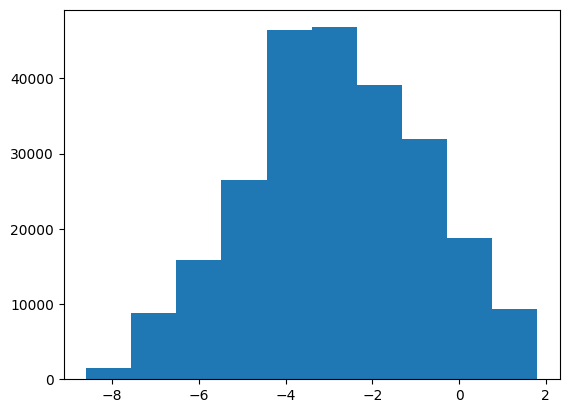

In [124]:
df_wind = ds['sfcWind']
import matplotlib.pyplot as plt
# Convert to pandas DataFrame (flattening time and spatial dimensions if needed)
df_wind = df_wind.to_dataframe().reset_index()
plt.hist(np.round(df_wind[~df_wind['sfcWind'].isna()]['longitude'],1))

In [ ]:
# -3.011912044445406 52.8811455063142


time
2024-07-01    1305000
Name: count, dtype: int64

In [125]:
df_wind[(np.round(df_wind['longitude'],3) == -3.012)]

,time,projection_y_coordinate,projection_x_coordinate,latitude,longitude,sfcWind
55425,2023-07-01,-138500.0,325500.0,48.649187,-3.011578,NaN
56325,2023-07-01,-137500.0,325500.0,48.658182,-3.011758,NaN
57225,2023-07-01,-136500.0,325500.0,48.667178,-3.011938,NaN
58125,2023-07-01,-135500.0,325500.0,48.676173,-3.012118,NaN
59025,2023-07-01,-134500.0,325500.0,48.685169,-3.012298,NaN
...,...,...,...,...,...,...
1189443,2023-07-01,1121500.0,343500.0,59.975041,-3.012313,NaN
1246144,2023-07-01,1184500.0,344500.0,60.540814,-3.011703,NaN
1247044,2023-07-01,1185500.0,344500.0,60.549792,-3.011984,NaN
1247944,2023-07-01,1186500.0,344500.0,60.558770,-3.012264,NaN


In [ ]:
 & (~df_wind['sfcWind'].isna())]

In [98]:
lat = 3.01
lon = 52.88
start = 1369728000
end = 1369729000
open_weather_data_api_key = '1548fbeeba9526658fd7bf8ba300189b'

open_weather_api_url = f'https://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start}&end={end}&appid={open_weather_data_api_key}'
df = requests.get(open_weather_api_url)

In [99]:
df.json()

{'cod': 401,
 'message': 'Invalid API key. Please see http://openweathermap.org/faq#error401 for more info.'}